# Baseline - preparación de los datos

In [60]:
import pandas as pd
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
comments = pd.read_csv("../data/comments.csv")

In [62]:
print(comments.shape)
comments.head(3)

(11113, 10)


,post_id,comment_id,author,created,score,body,vader_compound,sentiment_label,agrees,disagrees
0,1nvfumo,nh892fi,u/MuptonBossman,2025-10-01T18:22:39+00:00,2836,I remember watching Jane Goodall documentaries...,0.8748,pos,0,0
1,1nvfumo,nh87tvb,u/clownus,2025-10-01T18:16:40+00:00,3594,Highly suggest people check out podcast or tal...,0.6335,pos,0,0
2,1nvfumo,nh89xsl,u/Renegadeforever2024,2025-10-01T18:26:49+00:00,432,One of one,0.0000,neu,0,0


In [63]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"u\/\w+", "", text)
    text = re.sub(r"r\/\w+", "", text)
    text = re.sub(r"\n+", " ", text)
    text = re.sub(r"[^a-zA-Záéíóúüñ0-9\s]", "", text)
    text = re.sub(r"\s{2,}", " ", text).strip()
    return text


In [64]:
comments["clean_body"] = comments["body"].apply(clean_text)

comments[["body", "clean_body"]].head(3)

,body,clean_body
0,I remember watching Jane Goodall documentaries...,i remember watching jane goodall documentaries...
1,Highly suggest people check out podcast or tal...,highly suggest people check out podcast or tal...
2,One of one,one of one


In [65]:
comments = comments.drop_duplicates(subset=["clean_body"])
comments = comments.dropna(subset=["clean_body", "sentiment_label"])
comments = comments[comments["clean_body"].str.len() > 3]

print(comments.shape)

(10794, 11)


In [66]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_tokens(text):
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

comments["processed_text"] = comments["clean_body"].apply(preprocess_tokens)
comments[["clean_body", "processed_text"]].head(3)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\euroc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\euroc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\euroc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,clean_body,processed_text
0,i remember watching jane goodall documentaries...,remember watching jane goodall documentary ele...
1,highly suggest people check out podcast or tal...,highly suggest people check podcast talk one i...
2,one of one,one one


In [67]:
comments["sentiment_label"] = comments["sentiment_label"].map({
    "neg": 0,
    "neu": 1,
    "pos": 2
})

In [68]:
X = comments["processed_text"].astype(str)
y = comments["sentiment_label"]

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [70]:
tfidf = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1,2), 
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
svm = LinearSVC(random_state=42, class_weight='balanced')
svm.fit(X_train_tfidf, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,42


In [72]:
y_pred = svm.predict(X_test_tfidf)

In [73]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

Accuracy: 0.7443260768874479

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.69      0.45      0.55       279
           1       0.77      0.85      0.81      1269
           2       0.71      0.66      0.68       611

    accuracy                           0.74      2159
   macro avg       0.72      0.65      0.68      2159
weighted avg       0.74      0.74      0.74      2159



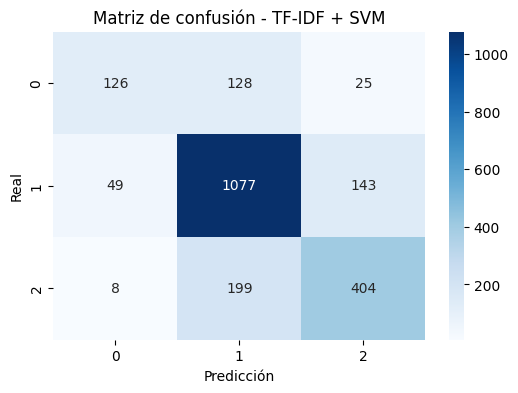

In [74]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión - TF-IDF + SVM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()